# Introduction

In this work, we are going to build joint alpha factors from the research paper **"The Formation Process of Winners and Losers in Momentum Investing".** 

The paper develops a model showing that past returns and the formation process of past returns have joint effect on future expected returns. That means, the past behavior of a stock that has become a winner (bullish) or a looser (bearish) plays an important role in momentum investing. 

The paper has shown that as long as two stocks share the same return over the past $n-$month, the future expected return of the stock whose historical prices are convex shaped is not lower than the one with concave-shaped historical prices. 

In a more concrete terms, stocks with convex-shaped historical prices will possess higher future expected returns than the one with concave-shaped historical prices.

A polynomial quandratic model is is used to approximate the nonlinear pattern of historical prices. 

In what follows, we are going to explore the paper to build a joint alpha factor for predicting future returns based on he formation patterns of past returns. The resulting alpha factor will be evaluated with performance metrics including information coefficient, turnover, sharpe ratio, and so on.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alphalens as al
from sklearn.linear_model import LinearRegression
from alphalens.plotting import*
from alphalens.tears import*
import talib 

In [5]:
idx = pd.IndexSlice
plt.style.use('ggplot')

## Mathematical formulation of winners and loosers  concepts from market's price dynimics


First of all we define the notion of convextiy and concavity:

A real valuedfunction $f$ is convex in an interval $\mathbb{D}$, if for every $\lambda \in [0, 1]$,

$$f(\lambda x + (1-\lambda y) ) \leq \lambda f(x) + (1-\lambda) f(y)\quad \forall x, y \in \mathbb{D} $$

A real valuedfunction $f$ is convex in an interval $\mathbb{D}$, if for every $\lambda \in [0, 1]$,

$$f(\lambda x + (1-\lambda y) ) \geq \lambda f(x) + (1-\lambda) f(y)\quad \forall x, y \in \mathbb{D} $$

$\textbf{ Properties}:$

1. $f$ is convex if and only if $f^{\prime\prime}(x) \geq 0 \quad \forall x\in \mathbb{D}$.
2. $f$ is concave if and only if $f^{\prime\prime}(x) \leq 0 \quad \forall x\in \mathbb{D}$.



$\textbf{ Example:}$
1. $f(x) = x^2$ is convex.
2. $f(x)=\sqrt{x}$ is concave.

### Approximating curves with polynomials
The stock's closing price curves are approximated with polynomials of the form $$y(t) = \beta t + \gamma t^2$$
where $t$ represents the number of days from the start of the stocks trajectory and $y(t)$ is the stock closing price at time $t$.

From the polynomial approximation, we can verify whether the approximation is convex or concave using $\textbf{Properties 1. or 2.}$, respectively.

### Accelerated Gain and Loss coefficients  from stock price's curvature

From now on, the polynomial approximation is re-written  by specifying the meaning of its coefficients. That is 
$$y(t) = \text{gain}\times t + \text{acceleration} \times t^2$$

The coefficient $\textbf{gain}$ represents the slop of the linear term of the polynomial. The linear coefficient primarily affects the tilt or slope of the curve, especially near the origin. Hence it captures the upward or downward trend of the stock price depending on whether it is posive or negative. 



The coefficient  $\textbf{acceleration}$ in front of the quadratic term $t^2$ determines the curvature of the graph. This is the "convexity" or "concavity" of the curve:
 1. If $\textbf{acceleration} > 0$, the curve is convex (or concave up), meaning it opens upwards. This is because as $t$ increases, the $t^2$ term, being squared, always adds a positive contribution to $y(t)$, pulling the curve upwards as t $t$ moves away from the origin. Therefore, if $\textbf{gain} > 0$, the trend of the stock is upward convex and reflects an **accelerated gain**, whereas if $\textbf{gain} < 0$, the trend of the stock is downward convex and reflects an **decelerated loss**. 
     
 2. If $\textbf{acceleration} < 0$, the curve is concave (or concave down), meaning it opens downwards. In this case, the contribution of the $t^2$ term is negative, pushing the curve downwards as $t$ moves away from the origin. Therefore, if $\textbf{gain} > 0$, the trend of the stock is downward concave and reflects a **decelerated gain**, whereas if $\textbf{gain} < 0$, the trend of the stock is downward concave and reflects a **accelerated loss**. 
 
 
Additionally, the magnitude of $\textbf{acceleration}$ affects how "sharp" or "broad" the curve is. Larger absolute values of $\textbf{acceleration}$ result in a steeper curve, indicating a stronger curvature, while smaller values produce a gentler curve.

In short, the quadratic coefficient $\textbf{acceleration}$ determines the overall shape of the curve (its convexity or concavity) and how pronounced that curvature is.

**Examples:**

1. **stock A**
- $\textbf{gain} = 10,  \textbf{acceleration} = 3 \to \text{accelerated gain}$


2. **stock B**
- $\textbf{gain} = 10, \textbf{acceleration} = - 3 \to \text{decelerated gain}$

We expect more positve return on **stock A** due to its $\text{accelerated gain}$. Therefore, when longing the two stocks, we should put more money on stock **A** and less money **B**

3. **Stock C**
- $\textbf{gain} = -10,  \textbf{acceleration} = 3 \to \text{decelerated loss}$
4. **Stock D**
- $\textbf{gain} = -10,  \textbf{acceleration} = -3 \to \text{accelerated loss}$

We expect more negative return on **stock D** due to its $\text{accelerated loss}$. Therefore, when shorting the two stocks, we should put more money on stock **D** and less money **C**


### Alpha Factor construction

We can now summurize that 
- When $\textbf{acceleration}(+) \times \textbf{gain}(+)$ is large, then the signal generally means to take a larger long positiom.

- When $\textbf{acceleration}(-) \times \textbf{gain}(-)$ is large, then the signal generally means to take a larger short position

Therefore, if we convert the $\textbf{gain}$ and $\textbf{acceleration}$ coefficients into ranks, then multiply them together, the product of the ranked $\textbf{gain}$ times ranked $\textbf{acceleration}$ would represent an alpha factor; a join alpha factor.

1. ranked $\textbf{gain}$ is small  and ranked $\textbf{acceleration}$ is small $\implies$  **large short** position, because the product is small.

2. ranked $\textbf{gain}$ is large  and ranked $\textbf{acceleration}$ is large $\implies$  **large long** position, because the product is large.


Note that 1. and 2. are conditional factors  because they are the combination of both momentum and convexity factors.


For the computation of the conditinal factors and the final joint factors, we need first to estimate the  coefficients  $\textbf{gain}$ and $\textbf{acceleration}$. For that, we will use a **multiple regression** where independent variables are the $t$ and $t^2$ and the dependent variable is the stock price (adjusted closing price). This regression will then give us estimates for the coefficients $\textbf{gain}$ and $\textbf{acceleration}$.

Finally, we will create our alpha factor first by converting $\textbf{gain}$ and $\textbf{acceleration}$ into ranks and them multiply the ranks together to create a join factor.

We will first select the universe of stocks by selecting a portfolio of the 10 most traded stocks over the 10 years which have at least 8 years of trading data. We need the most traded stocks because we are aiming to minimise the liquitiy issue that can be a real world constraint against trading strategies.

For that, we build a helper function to construct a universe of that assets that fit the above requirements.

In [6]:
# build a function to construct a  universe of assets and their historical trading data

def select_and_process_historical_data(filename, traded_year=8, number_stocks=10):
    '''
    filename: is the csv file name that contains the historical 
                trading data to be processed and used to construct the portfolio
                
    '''
    data = pd.read_csv(filename, index_col=[0,1], parse_dates=True)
    
    # filter the dataframe by selecting the adjencent prices and select 10 years of trading data
    data = data.filter(like='adj_').rename(columns=lambda x: x.replace('adj_', '')).loc[idx[:, '2006':'2016'], :].dropna()
    
    # select the assets: we select the 10 most traded assets over the 10 years with at least 8 years of data
    dv = data.close.mul(data.volume)
    dv = dv.unstack('ticker').dropna(thresh=traded_year*252, axis=1).rank(axis=1, ascending=True).mean().nlargest(number_stocks)
    selected_assets = dv.index.tolist()
    universe = data.loc[idx[selected_assets, :], :]
    
    # remove data outlier by removing returns that are at least 100 per cent
    universe = universe[universe.close.pct_change().between(-1, 1)]
    
    
    return universe

In [25]:
universe = select_and_process_historical_data('HISTORIC_PRICES.csv', 8, 10)
universe

/var/folders/4q/7cmydxpd4l9c0csvvm8tb9sm0000gn/T/ipykernel_1613/3331272211.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filename, index_col=[0,1], parse_dates=True)


open       high        low      close       volume
ticker date                                                               
AAPL   2006-01-04   9.655252   9.764489   9.574288   9.634690  154900900.0
       2006-01-05   9.616698   9.625694   9.477903   9.558867  112355600.0
       2006-01-06   9.669389   9.857019   9.580714   9.805613  176114400.0
       2006-01-09   9.860874   9.921276   9.733646   9.773485  168760200.0
       2006-01-10   9.799188  10.524006   9.745212  10.391637  569967300.0
...                      ...        ...        ...        ...          ...
CSCO   2016-12-23  29.484966  29.542893  29.349802  29.475311    9167598.0
       2016-12-27  29.581511  29.755293  29.542893  29.620129   14175488.0
       2016-12-28  29.639438  29.707020  29.301529  29.369111   12022231.0
       2016-12-29  29.320838  29.494620  29.282220  29.407729   10995584.0
       2016-12-30  29.504275  29.542893  29.089130  29.176020   20190029.0

[27688 rows x 5 columns]

In [26]:
universe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27688 entries, ('AAPL', Timestamp('2006-01-04 00:00:00')) to ('CSCO', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    27688 non-null  float64
 1   high    27688 non-null  float64
 2   low     27688 non-null  float64
 3   close   27688 non-null  float64
 4   volume  27688 non-null  float64
dtypes: float64(5)
memory usage: 1.9+ MB


In [27]:
selected_assets = universe.index.unique('ticker')
selected_assets

Index(['AAPL', 'GOOGL', 'MSFT', 'BAC', 'XOM', 'C', 'JPM', 'GE', 'INTC',
       'CSCO'],
      dtype='object', name='ticker')

In [28]:
# we also need the adjecent close prices in order to build the alpha
close_prices = universe.close.unstack('ticker').dropna()
close_prices

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-04,9.634690,223.309335,20.452419,36.857078,42.736042,407.547758,29.572932,23.323910,17.966813,14.750795
2006-01-05,9.558867,226.318624,20.467586,36.904554,42.524441,409.569491,29.662501,23.264478,18.216519,15.163982
2006-01-06,9.805613,233.550949,20.406919,36.849165,43.363547,409.569491,29.871497,23.422964,18.244256,15.511060
2006-01-09,9.773485,234.172919,20.369002,36.872903,43.341657,407.631996,30.356667,23.363532,18.355206,15.750708
2006-01-10,10.391637,235.607297,20.475169,36.564310,43.677300,408.895580,30.401452,23.238064,18.112434,15.676335
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,115.080808,807.800000,61.864790,22.346222,87.393822,60.109470,85.126373,31.055560,35.749710,29.475311
2016-12-27,115.811668,809.930000,61.903920,22.356110,87.432359,60.208026,85.204605,31.075043,35.846409,29.620129
2016-12-28,115.317843,804.570000,61.620226,22.079254,86.998810,59.173185,84.588527,30.880215,35.420932,29.369111


### Building the alpha factor

#### describing price over time with a curve

To describe price over time, we'll use integers that increment each day as the independent variable.  We'll use price as the dependent variable.  As in the introduction, we describe the trajectory of price over time using a polynomial.

$ ClosePrice_i = \beta \times time_i + \gamma \times time_i^2$

where $\beta$  and $gamma$ represent the gain and acceleration coefficients respectively.

First, we'll use `numpy.arange(days)` where days might be 5 for a week, or 252 for a year's worth of data.  So we'll have integers represent the days in this window.

To create a 2D numpy array, we can combine them together in a list.  By default, the `numpy.arange` arrays are row vectors, so we use transpose to make them column vectors (one column for each independent variable).

We instantiate a LinearRegression object, then call `.fit(X,y)`, passing in the independent and depend variables.  

We'll use `.coefficient` to access the regression coefficients estimated from the data.  There is one for each independent variable.

The function below will implement the regression using closing prices of our universe of assets.

In [29]:
def find_coefficient_with_regression(assets, close_prices, time_window_size=5):
    
    """
        VARIABLES 
           assets: list pf tickers
           close_price: universe's adjacent close prices 
           time_window: the period chosed to for the regression (independent variables)
           
        RETURNS:
            list of two Dataframes one for the gain coefficients, one for the acceleration coefficients
    """
    
    
    # set the dependent variables
    t1 = 1 + np.arange(time_window_size)
    t2 = t1**2
    X  = np.array([t1, t2]).T
    list_gain_coefs_df = []
    list_acc_coefs_df = []
    
    for ticker in assets:
        
        ticker_price = close_prices[ticker]
        N = len(close_prices[ticker])
        liste_dates = []
        list_gain = []
        list_acc = []
    
        for start in range(N - time_window_size + 1):
            end = start + time_window_size
            y, date_ = ticker_price[start:end].values, ticker_price[start:end].index[-1]
            liste_dates.append(date_)
            model = LinearRegression()
            model.fit(X, y)
            gain_coef = model.coef_[0]
            acc_coef = model.coef_[1]
            
            list_gain.append(gain_coef)
            list_acc.append(acc_coef)
        
        # create a one column df of gain coefs and append it to a list    
        gain_df_per_ticker = pd.DataFrame(list_gain, index=liste_dates, columns=[ticker])
        gain_df_per_ticker.index.name = 'date'
        list_gain_coefs_df.append(gain_df_per_ticker)
        
        # create one column df of acceleration coefs and append it to a list
        acc_df_per_ticker = pd.DataFrame(list_acc, index=liste_dates, columns=[ticker])
        acc_df_per_ticker.index.name = 'date'
        list_acc_coefs_df.append(acc_df_per_ticker)
        
    gains_df = pd.concat(list_gain_coefs_df, axis=1)
    accs_df =  pd.concat(list_acc_coefs_df, axis=1)
    list_alphas = [gains_df, accs_df]
    
    
    return list_alphas
        


In [30]:
list_alpas = find_coefficient_with_regression(selected_assets, close_prices, 21)

In this way we have estimated the gains and acceleration coefficients for each ticker and for each time window

In [31]:
# The gain coefficients
gain_alpha = list_alpas[0]
gain_alpha.columns.name = 'ticker'
gain_alpha.stack('ticker')

date        ticker
2006-02-02  AAPL      0.157950
            GOOGL     0.299354
            MSFT     -0.121639
            BAC      -0.180983
            XOM       0.208153
                        ...   
2016-12-30  C         0.625823
            JPM       0.569654
            GE        0.084329
            INTC      0.489902
            CSCO      0.220746
Length: 27480, dtype: float64

In [32]:
# The acceleration coefficients
acceleration_alpha = list_alpas[1]
acceleration_alpha.columns.name = 'ticker'
acceleration_alpha.stack('ticker')

date        ticker
2006-02-02  AAPL     -0.008950
            GOOGL    -0.078832
            MSFT      0.006776
            BAC       0.002773
            XOM      -0.003976
                        ...   
2016-12-30  C        -0.021696
            JPM      -0.015945
            GE       -0.001987
            INTC     -0.016247
            CSCO     -0.007512
Length: 27480, dtype: float64

### Creating the conditional factor
As mentionned in the previous section, the alpha factor we are going to build is actually a conditional factor joining the acceleration and regression factors. Therefore, we create the alpha factor as the product of the gain and acceleration.

To do that, we will first rank both gain and accelaration factors by ascending order and multiply the ranked factors to yield our final alpha factor.



In [33]:
def acclerated_gain_loss_alpha_factor(gain_alpha, acceleration_alpha):   
    
    ranked_gain = gain_alpha.rank(axis=1, ascending=True, method='first').astype(int)
    ranked_acceleration = acceleration_alpha.rank(axis=1, ascending=True, method='first').astype(int)

    ranked_joint_factor = ranked_gain*ranked_acceleration

    ranked_joint_factor = ranked_joint_factor.rank(axis=1, ascending=True, method='first').astype(int)
    
    return ranked_joint_factor


In [34]:
ranked_acceleration_gain_loss_alpha = acclerated_gain_loss_alpha_factor(gain_alpha, acceleration_alpha)
ranked_acceleration_gain_loss_alpha

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-02-02,4,2,10,5,8,1,6,9,3,7
2006-02-03,3,1,10,6,7,2,5,8,4,9
2006-02-06,3,1,10,5,6,2,8,7,4,9
2006-02-07,4,1,10,7,3,2,8,9,5,6
2006-02-08,4,1,8,7,3,2,9,6,5,10
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,9,2,10,4,8,7,5,3,6,1
2016-12-27,10,2,5,9,6,8,4,1,7,3
2016-12-28,10,1,8,6,3,9,7,2,5,4


As we can see above, we have now created our alpha factor from the combination of estimated gain and acceleration coefficients

In [35]:
ranked_acceleration_gain_loss_alpha = ranked_acceleration_gain_loss_alpha.stack('ticker')
ranked_acceleration_gain_loss_alpha

date        ticker
2006-02-02  AAPL       4
            GOOGL      2
            MSFT      10
            BAC        5
            XOM        8
                      ..
2016-12-30  C          9
            JPM       10
            GE         2
            INTC       7
            CSCO       4
Length: 27480, dtype: int64

### Evaluation of the alpha factor via alphalens library

First, we will cleand tie the ranked alpha values to chosen forward returns and quantiles in a suitable way for the estimation of evaluation metrics.

In [36]:
HOLDINGS = (1, 2, 3, 4)
quantiles = 5
alphalens_data = al.utils.get_clean_factor_and_forward_returns(factor=ranked_acceleration_gain_loss_alpha,
                                                             prices=close_prices,
                                                             periods=HOLDINGS,
                                                             quantiles=quantiles)

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [37]:
alphalens_data

1D        2D        3D        4D  factor  \
date       asset                                                   
2006-02-02 AAPL  -0.003509 -0.066574 -0.062413 -0.045631       4   
           GOOGL -0.036575 -0.027623 -0.071003 -0.068074       2   
           MSFT  -0.005058 -0.018425 -0.026734 -0.027818      10   
           BAC   -0.008057 -0.001611  0.001151  0.005295       5   
           XOM   -0.009040  0.000323 -0.022599 -0.020016       8   
...                    ...       ...       ...       ...     ...   
2016-12-23 C      0.001640 -0.015576 -0.026398 -0.025578       7   
           JPM    0.000919 -0.006318 -0.013326 -0.008731       5   
           GE     0.000627 -0.005646 -0.005332 -0.008783       3   
           INTC   0.002705 -0.009197 -0.008385 -0.018934       6   
           CSCO   0.004913 -0.003603 -0.002293 -0.010154       1   

                  factor_quantile  
date       asset                   
2006-02-02 AAPL                 2  
           GOOGL                1  
           MSFT                 5  
           BAC                  3  
           XOM                  4  
...                           ...  
2016-12-23 C                    4  
           JPM                  3  
           GE                   2  
           INTC                 3  
           CSCO                 1  

[27440 rows x 6 columns]

In [38]:
factor_returns = al.performance.factor_returns(alphalens_data)
factor_returns

,1D,2D,3D,4D
date,,,,
2006-02-02,0.004693,0.004287,0.005348,0.008955
2006-02-03,0.000242,0.006050,0.014141,0.021684
2006-02-06,0.006523,0.014928,0.023245,0.019260
2006-02-07,0.001356,0.008880,0.007410,0.015682
2006-02-08,0.008919,0.007929,0.015266,0.016645
...,...,...,...,...
2016-12-19,-0.000321,-0.001135,0.000648,0.001410
2016-12-20,-0.001374,0.000856,0.001142,0.000976
2016-12-21,0.001461,0.000505,-0.000146,0.000292


In [39]:
def calculate_sharpe_ratio(factor_returns_df):
    """
        factor_returns_df: the alpha returns computed. 
    """
    sharpe_ratio = np.sqrt(252)*factor_returns_df.mean().div(factor_returns_df.std()).to_frame().rename(columns={0:'sharpe ratio'})
    sharpe_ratio.index.name = 'holding periods'
    
    return sharpe_ratio

In [40]:
sharpe_ratio_result  = calculate_sharpe_ratio(factor_returns)
sharpe_ratio_result

,sharpe ratio
holding periods,
1D,0.307151
2D,0.222577
3D,0.191805
4D,0.178802


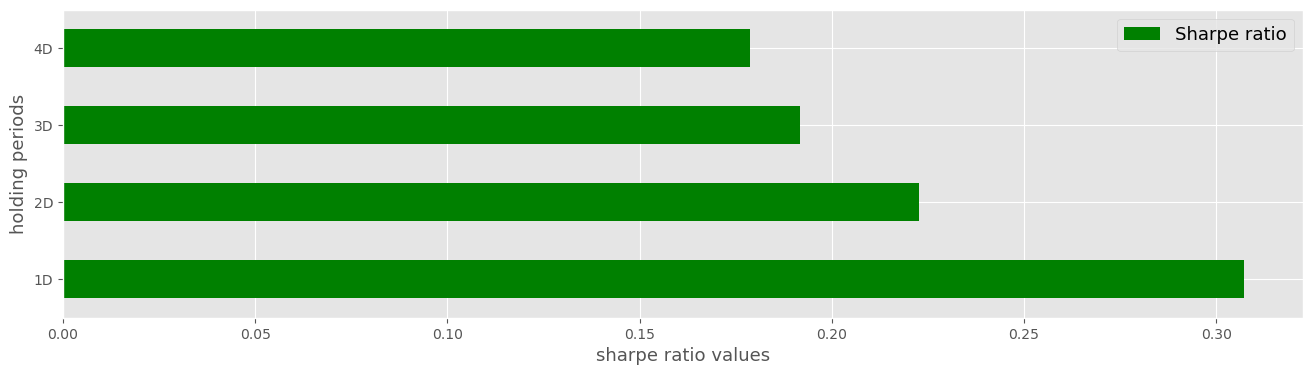

In [41]:
sharpe_ratio_result.plot.barh(color='g', figsize=(16, 4))
plt.legend(['Sharpe ratio'], fontsize=13)
plt.xlabel('sharpe ratio values', fontsize=13)
plt.ylabel('holding periods', fontsize=13);

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1,2,1.5,0.500046,5488,20.0
2,3,4,3.5,0.500046,5488,20.0
3,5,6,5.5,0.500046,5488,20.0
4,7,8,7.5,0.500046,5488,20.0
5,9,10,9.5,0.500046,5488,20.0


Returns Analysis


,1D,2D,3D,4D
Ann. alpha,0.043,0.031,0.028,0.027
beta,-0.077,-0.112,-0.122,-0.136
Mean Period Wise Return Top Quantile (bps),1.763,1.752,2.009,1.420
Mean Period Wise Return Bottom Quantile (bps),0.078,0.624,1.170,0.919
Mean Period Wise Spread (bps),1.685,1.187,0.944,0.641


Information Analysis


,1D,2D,3D,4D
IC Mean,0.011,0.011,0.011,0.010
IC Std.,0.340,0.335,0.334,0.337
Risk-Adjusted IC,0.032,0.033,0.034,0.029
t-stat(IC),1.670,1.718,1.770,1.527
p-value(IC),0.095,0.086,0.077,0.127
IC Skew,-0.008,-0.000,-0.001,-0.028
IC Kurtosis,-0.432,-0.448,-0.456,-0.441


Turnover Analysis


,1D,2D,3D,4D
Quantile 1 Mean Turnover,0.213,0.338,0.418,0.470
Quantile 2 Mean Turnover,0.459,0.600,0.675,0.715
Quantile 3 Mean Turnover,0.574,0.671,0.712,0.735
Quantile 4 Mean Turnover,0.586,0.670,0.703,0.721
Quantile 5 Mean Turnover,0.417,0.543,0.621,0.664


,1D,2D,3D,4D
Mean Factor Rank Autocorrelation,0.743,0.581,0.464,0.385


<Figure size 576x396 with 0 Axes>

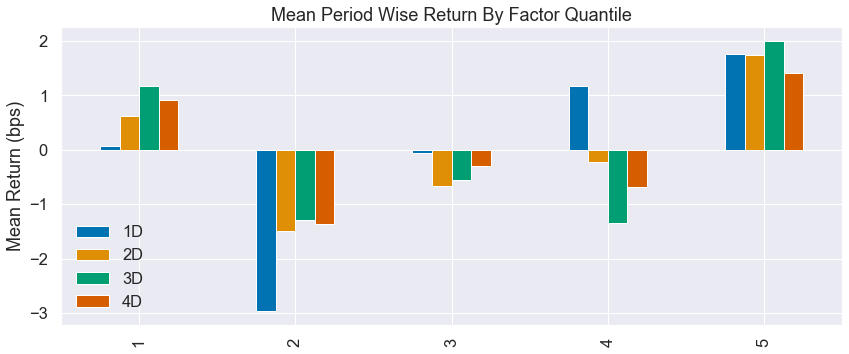

In [21]:
create_summary_tear_sheet(alphalens_data);